In [1]:
import numpy as np
import pandas as pd
import pickle
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
from torch import nn, optim
from tqdm import tqdm

from utils.my_utils_for_DVRL import *
from utils.general_utils import *

load data from data/train_dev_test_split/1/fold-0/...
Loading embedding from cache...
load data from data/train_dev_test_split/2/fold-0/...
Loading embedding from cache...
Creating predictor model...
QWK: 0.6144
Creating predictor model...
QWK: 0.7528
Creating predictor model...
QWK: 0.7171
Creating predictor model...
QWK: 0.7492
Creating predictor model...
QWK: 0.7274
Creating predictor model...
QWK: 0.7584
Creating predictor model...
QWK: 0.7148
Creating predictor model...
QWK: 0.7830
Creating predictor model...
QWK: 0.7891
Creating predictor model...
QWK: 0.7863
Creating predictor model...
QWK: 0.7798
Creating predictor model...
QWK: 0.7771
Creating predictor model...
QWK: 0.7791
Creating predictor model...
QWK: 0.7754
Creating predictor model...
QWK: 0.7842
Creating predictor model...
QWK: 0.7937
Creating predictor model...
QWK: 0.7952
Creating predictor model...
QWK: 0.7921
Creating predictor model...
QWK: 0.7926
Creating predictor model...
QWK: 0.7871
Creating predictor model...


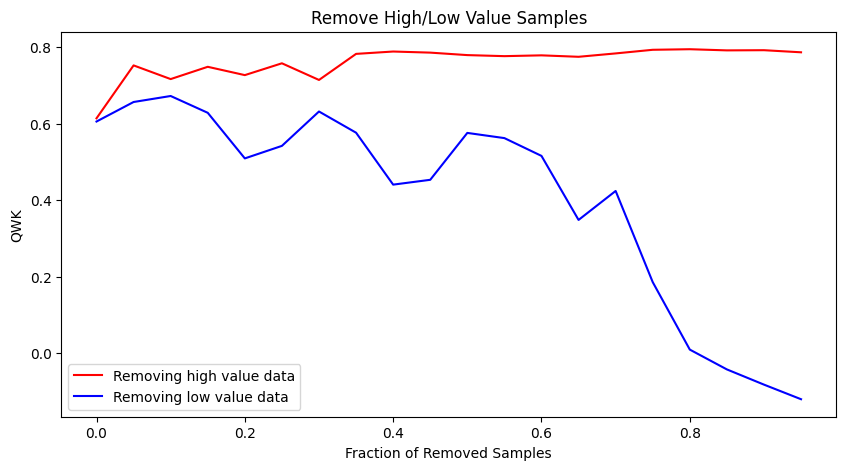

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load data 1
test_prompt_id = 1
data_path = 'data/train_dev_test_split/' + str(test_prompt_id) + '/fold-0/'
print(f'load data from {data_path}...')
data = load_data(data_path)

y_train = np.array(data['train']['label'])
y_dev = np.array(data['dev']['label'])
y_test = np.array(data['test']['label'])

minscore, maxscore = get_min_max_scores()[test_prompt_id]['score']
y_train1 = (y_train - minscore) / (maxscore - minscore)
y_dev1 = (y_dev - minscore) / (maxscore - minscore)
y_test1 = (y_test - minscore) / (maxscore - minscore)

print('Loading embedding from cache...')
train_features1 = pickle.load(open(data_path + 'cache/train_features.pkl', 'rb'))
dev_features1 = pickle.load(open(data_path + 'cache/dev_features.pkl', 'rb'))
test_features1 = pickle.load(open(data_path + 'cache/test_features.pkl', 'rb'))

# Load data 2
data_path = 'data/train_dev_test_split/' + str(2) + '/fold-0/'
print(f'load data from {data_path}...')
data = load_data(data_path)

y_train = np.array(data['train']['label'])
y_dev = np.array(data['dev']['label'])
y_test = np.array(data['test']['label'])

minscore, maxscore = get_min_max_scores()[2]['score']
y_train2 = (y_train - minscore) / (maxscore - minscore)
y_dev2 = (y_dev - minscore) / (maxscore - minscore)
y_test2 = (y_test - minscore) / (maxscore - minscore)

print('Loading embedding from cache...')
train_features2 = pickle.load(open(data_path + 'cache/train_features.pkl', 'rb'))
dev_features2 = pickle.load(open(data_path + 'cache/dev_features.pkl', 'rb'))
test_features2 = pickle.load(open(data_path + 'cache/test_features.pkl', 'rb'))

high_qwks = []
for p in np.arange(0.0, 1.0, 0.05):
    # Create predictor
    print('Creating predictor model...')
    pred_model = nn.Sequential(
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

    train_features = np.concatenate([train_features1, train_features2], axis=0)
    y_train = np.concatenate([y_train1, y_train2[::-1]], axis=0)

    weights = get_sample_weight(np.load('estimated_data_value.npy'), top_p=p, ascending=True)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_dev1, y_pred, test_prompt_id, 'score')
    print(f'QWK: {qwk:.4f}')
    high_qwks.append(qwk)

low_qwks = []
for p in np.arange(0.0, 1.0, 0.05):
    # Create predictor
    print('Creating predictor model...')
    pred_model = nn.Sequential(
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

    train_features = np.concatenate([train_features1, train_features2], axis=0)
    y_train = np.concatenate([y_train1, y_train2[::-1]], axis=0)

    weights = get_sample_weight(np.load('estimated_data_value.npy'), top_p=p, ascending=False)
    history = fit_func(pred_model, train_features, y_train, batch_size=256, epochs=100, device=device, sample_weight=weights)

    y_pred = pred_func(pred_model, dev_features1, batch_size=256, device=device)
    qwk = calc_qwk(y_dev1, y_pred, test_prompt_id, 'score')
    print(f'QWK: {qwk:.4f}')
    low_qwks.append(qwk)

import matplotlib.pyplot as plt
# plot loss
p = np.arange(0.0, 1.0, 0.05)
plt.figure(figsize=(10, 5))
plt.plot(p, high_qwks, label='Removing high value data', color='red')
plt.plot(p, low_qwks, label='Removing low value data', color='blue')
plt.title('Remove High/Low Value Samples')
plt.xlabel('Fraction of Removed Samples')
plt.ylabel('QWK')
plt.legend()
plt.show()

# import matplotlib.pyplot as plt
# # plot loss
# epochs = list(range(1, 100+1))
# plt.figure(figsize=(10, 5))
# plt.plot(epochs, history, label='Train', color='red')
# plt.title('Loss over Epochs')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()